In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
from sqlalchemy import create_engine
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")

from credential import dwh_secret,antares_secret 


def get_engine(db_name):
    if db_name == antares_secret['dbname']:
        user = antares_secret['user']
        password = antares_secret['password']
        host = antares_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{db_name}')
    elif db_name == dwh_secret['dbname']:
        user = dwh_secret['user'] 
        password = dwh_secret['password']
        host = dwh_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{db_name}')
    return engine
        



def execute(SQL, db_name = 'dwh'):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(db_name)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = end_time - start_time  # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    return df
    

In [2]:
start_date = datetime.strptime("2024-04-18", "%Y-%m-%d")
end_date = datetime.strptime("2024-04-22", "%Y-%m-%d")

In [3]:
query = f''' WITH users_ab AS ( 
                    SELECT 
                    event_json->>'yappy_device_id' AS yappy_device_uuid,
                    appmetrica_device_id,
                    event_json->>'group' AS experiment_group
                    FROM appmetrica.fct_ods_appm_export_events t1 
                    WHERE event_date_msk BETWEEN '{start_date}' AND '{end_date}'
                    AND event_name='experiment' 
                    AND event_json->>'group' IN ('lenta__rltpw_test_B','lenta__rltpw_control_A')
                    GROUP BY 1,2,3
            ),

            users_w_experiment_empty AS (
                    SELECT 
                    DISTINCT 
                    event_json->>'yappy_device_id' AS yappy_device_uuid
                    FROM appmetrica.fct_ods_appm_export_events t1 
                    WHERE event_date_msk BETWEEN '{start_date}' AND '{end_date}'
                    AND event_name='experiment_empty' 
                    GROUP BY 1

                    ),

            ab_users_dublicate AS  (---------Дедупликация ------------------
                    SELECT yappy_device_uuid
                    FROM users_ab
                    GROUP BY 1
                    HAVING count(yappy_device_uuid)>1
            ),

            ab_users_dublicate_2 AS ( --------Дедупликация -----------
                    SELECT yappy_device_uuid
                    FROM users_ab
                    GROUP BY 1
                    HAVING count(appmetrica_device_id)>1

            ),

            ab_users_wo_dublicate AS  (-------Убираем пользователей, которые попали в несколько групп и получили событие experiment_empty
                    SELECT 
                    t1.*,
                    CASE WHEN t3.yappy_device_uuid IS NULL THEN 0 ELSE 1 END AS empty_user
                    FROM users_ab AS t1
                    LEFT JOIN ab_users_dublicate AS t2
                    ON t1.yappy_device_uuid=t2.yappy_device_uuid
                    LEFT JOIN users_w_experiment_empty  AS t3
                    ON t1.yappy_device_uuid=t3.yappy_device_uuid
                    LEFT JOIN ab_users_dublicate_2  AS t4
                    ON t1.yappy_device_uuid=t4.yappy_device_uuid
                    WHERE t2.yappy_device_uuid IS NULL AND t4.yappy_device_uuid IS NULL 
            )


            SELECT 
            t1.date_msk,
            t1.device_id,
            t3.empty_user,
            CASE WHEN t4.yappy_device_uuid IS NULL THEN 'Удержанный' ELSE 'Новый' END AS new_type,
            t1.score_str,
            t1.profile_type,
            t1.bot_flag,
            t1.os_name,
            t1.tracker_name,
            t1.traffic_type,
            t2.os_version,
            t2.app_version_name,
            t2.device_manufacturer,
            t2.device_model,
            t2.country_type,
            t3.experiment_group,
            t1.watchtime,
            t1.broadcast
            FROM
            (SELECT
                date_msk,
                lower(device_id) AS device_id,
                CASE WHEN profile_uuid IS NOT NULL THEN 'Зарег' ELSE 'Незарег' END profile_type,
                client AS os_name,
                tracker_name,
                traffic_type,
                score_str,
                bot_flag,
                sum(ttl_depth_ms)/1000 AS watchtime,
                sum(cnt_video) AS broadcast
                FROM dds.fct_dds_backend_streams_watchtime_by_user
                WHERE reference=1 AND date_msk BETWEEN '{start_date}' AND '{end_date}'
                GROUP BY 1,2,3,4,5,6,7,8
            ) AS t1

            LEFT JOIN (SELECT 
                lower(yappy_device_uuid::TEXT) AS yappy_device_uuid,
                max(device_model) AS device_model,
                max(device_manufacturer) AS device_manufacturer,
                max(country_type) AS country_type,
                max(app_version_name) AS app_version_name,
                max(os_version) AS os_version
                FROM dds.fct_dds_clear_appm_events
                WHERE event_date_msk BETWEEN '{start_date}' AND '{end_date}'
                AND event_name IN ('video_visible','video_watch','video_watched','video_add_like','video_add_comment','video_share')
                AND reference='tape'
                GROUP BY 1
                ) t2
            ON t1.device_id=t2.yappy_device_uuid	


            LEFT JOIN (SELECT lower(yappy_device_uuid::TEXT) AS yappy_device_uuid,empty_user,experiment_group 
                       FROM  ab_users_wo_dublicate
                       ) AS  t3
            ON t1.device_id=t3.yappy_device_uuid
            
            LEFT JOIN (SELECT event_date_msk,lower(yappy_device_uuid::TEXT) AS yappy_device_uuid FROM dds.fct_dds_appm_first_event_device_uuid_app_open
                       WHERE event_date_msk BETWEEN '{start_date}' AND '{end_date}'
                       ) AS t4
            ON t1.device_id=t4.yappy_device_uuid AND t1.date_msk=t4.event_date_msk
            '''
df = execute(query,db_name='dwh')
df['date_msk'] = df['date_msk'].astype('datetime64[ns]')  
df = df[df['watchtime'].notna()]
df = df[df['broadcast'].notna()] 
df['watchtime'] = df['watchtime'].astype('float')
df['broadcast'] = df['broadcast'].astype('int')

Время выполнения функции: 26.221238613128662 секунд


## Новые пользователи (Незареги + Зареги). Исключены каналы аниме Стаса 

In [124]:
df_unregister = df[(df['new_type'] == 'Новый') & (df['empty_user'] == 0) & (df['bot_flag']==0) & (~df['score_str'].isin(['mid','high'])) & (~df['tracker_name'].isin(['RW_Yandex_test_anime_Android','RW_VK_test_anime_IOS','RW_VK_test_anime_Android']))]

df_unregister_agg = df_unregister.groupby(['date_msk','device_id','experiment_group']).agg({'watchtime':'sum','broadcast':'sum'}).reset_index()

cnt_watchtime_mean_std_n = df_unregister_agg.groupby(['date_msk','experiment_group'])['watchtime'].agg(['mean','var','std','count']).reset_index()
cnt_broadcast_mean_std_n = df_unregister_agg.groupby(['date_msk','experiment_group'])['broadcast'].agg(['mean','var','std','count']).reset_index()


cnt_watchtime_mean_std_n

,date_msk,experiment_group,mean,var,std,count
0,2024-03-07,lenta_anime_control_A,54.892644,27912.975927,167.071769,1628
1,2024-03-07,lenta_anime_test_B,48.604927,33304.325172,182.494726,1635
2,2024-03-07,lenta_anime_test_C,66.195573,48382.197541,219.959536,1743
3,2024-03-08,lenta_anime_control_A,77.316296,73954.725234,271.946181,2070
4,2024-03-08,lenta_anime_test_B,56.856199,43386.714338,208.294778,2126
5,2024-03-08,lenta_anime_test_C,59.018241,28240.445844,168.048939,2058
6,2024-03-09,lenta_anime_control_A,99.377318,72620.486652,269.481886,1657
7,2024-03-09,lenta_anime_test_B,88.568298,202536.500938,450.040555,1714
8,2024-03-09,lenta_anime_test_C,84.443300,75776.534295,275.275379,1651
9,2024-03-10,lenta_anime_control_A,93.281520,80227.407403,283.244430,2553


In [125]:
#cnt_visible_mean_std_n['ci'] = cnt_visible_mean_std_n
alpha = 0.05
t_alpha = stats.norm.ppf(1 - alpha / 2)


cnt_watchtime_mean_std_n['ci_plus'] = cnt_watchtime_mean_std_n['mean'] + t_alpha * np.sqrt(cnt_watchtime_mean_std_n['var'] / cnt_watchtime_mean_std_n['count'])
cnt_watchtime_mean_std_n['ci_minus'] = cnt_watchtime_mean_std_n['mean'] - t_alpha * np.sqrt(cnt_watchtime_mean_std_n['var'] / cnt_watchtime_mean_std_n['count'])

cnt_broadcast_mean_std_n['ci_plus'] = cnt_broadcast_mean_std_n['mean'] + t_alpha * np.sqrt(cnt_broadcast_mean_std_n['var'] / cnt_broadcast_mean_std_n['count'])
cnt_broadcast_mean_std_n['ci_minus'] = cnt_broadcast_mean_std_n['mean'] - t_alpha * np.sqrt(cnt_broadcast_mean_std_n['var'] / cnt_broadcast_mean_std_n['count'])

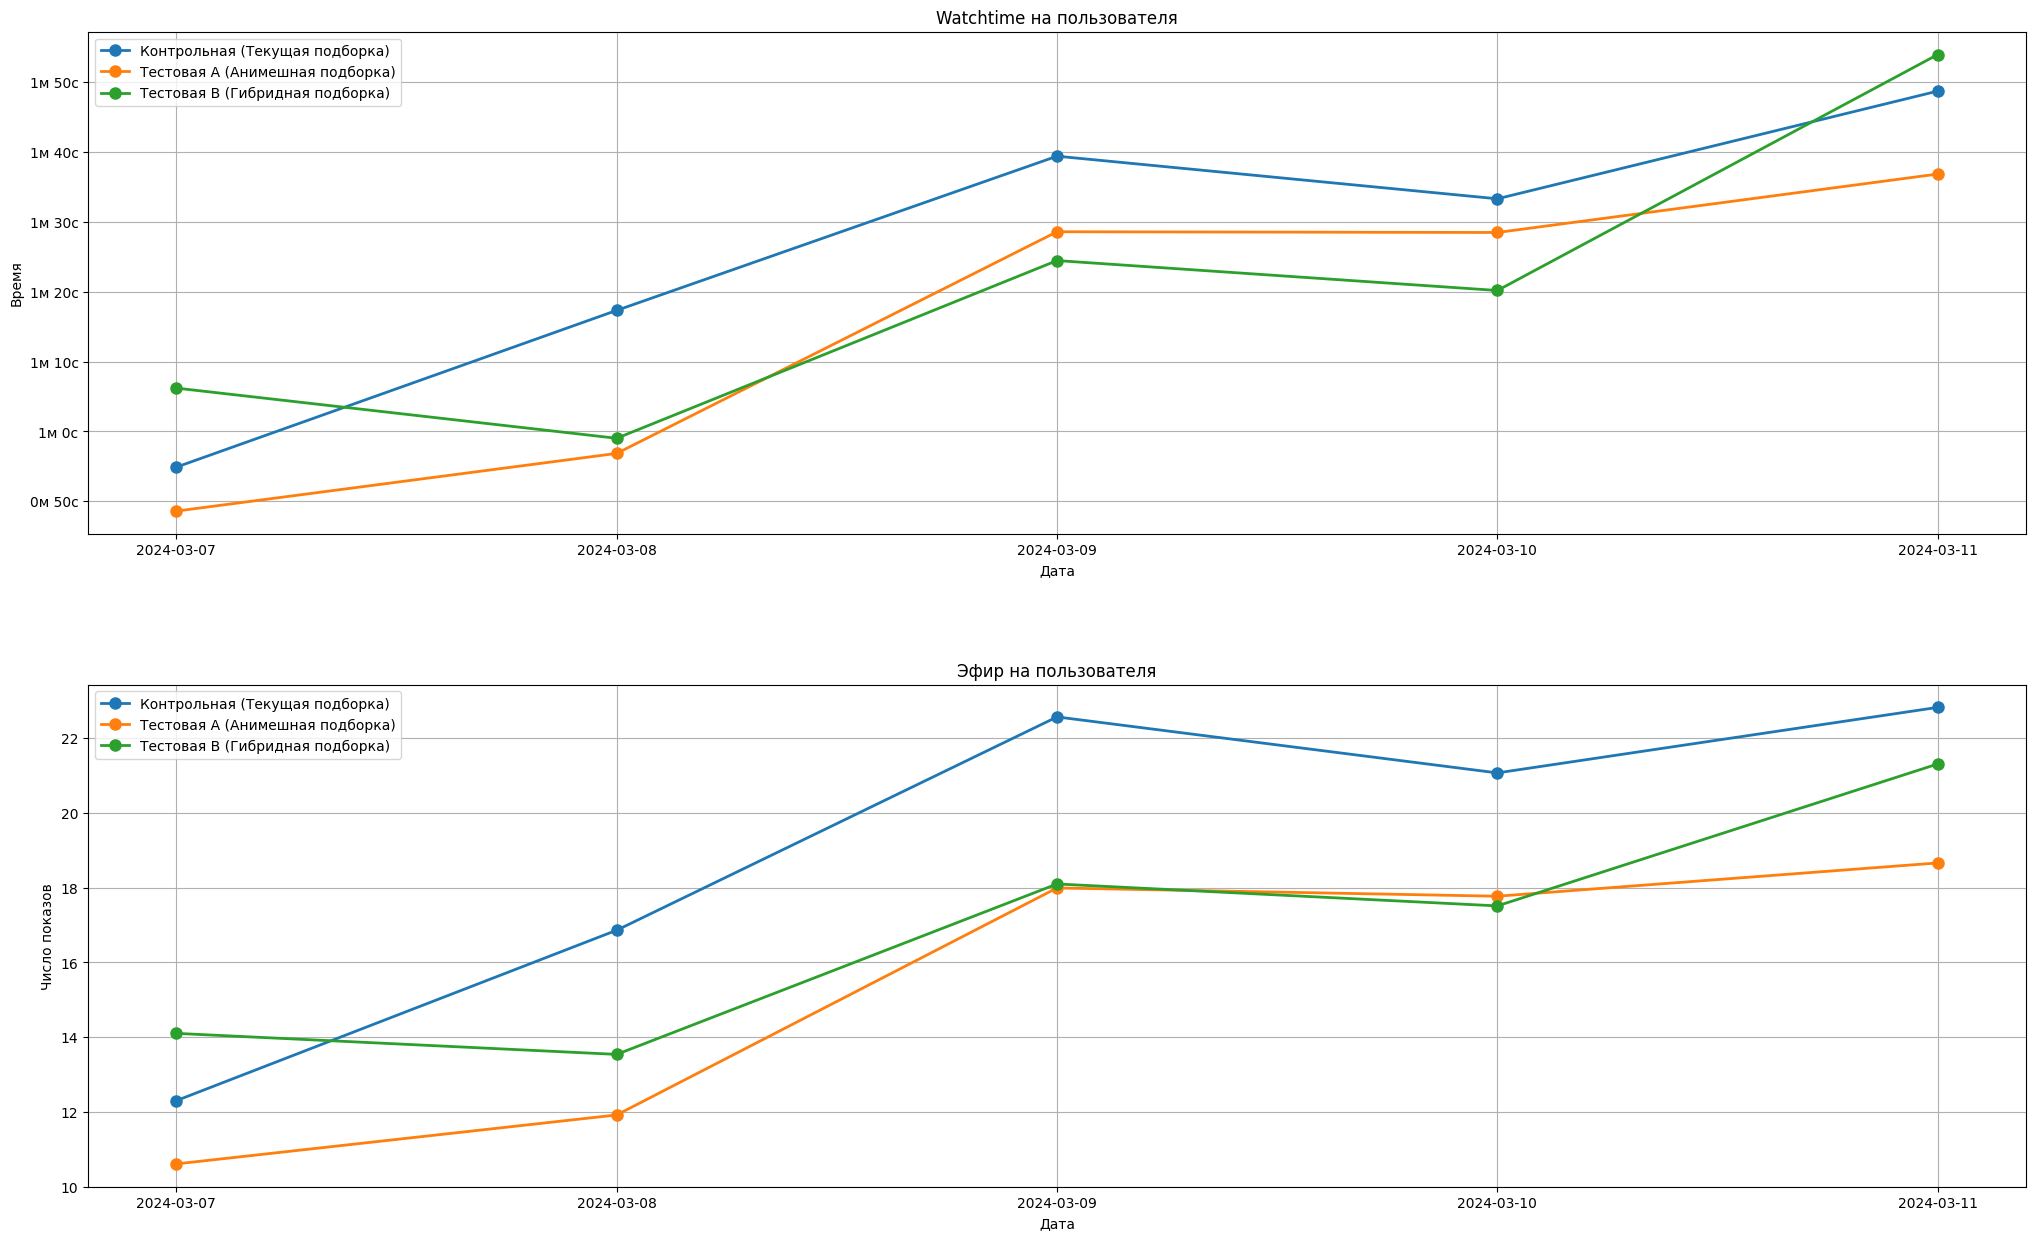

In [126]:
import matplotlib.dates as mdates

fig,axes = plt.subplots(2,1,figsize=(25,15))

def format_func(value, tick_number):
    minutes = int(value) // 60
    seconds = int(value) % 60
    return f"{minutes}м {seconds}с"

plt.subplots_adjust(hspace=0.3)

for i in cnt_watchtime_mean_std_n['experiment_group'].unique():
    watchtime = cnt_watchtime_mean_std_n[cnt_watchtime_mean_std_n['experiment_group']==i]
    axes[0].plot(watchtime['date_msk'], watchtime['mean'], label=i,marker='o',linewidth=2, markersize=8)

for i in cnt_broadcast_mean_std_n['experiment_group'].unique():
    broadcast = cnt_broadcast_mean_std_n[cnt_broadcast_mean_std_n['experiment_group']==i]    
    axes[1].plot(broadcast['date_msk'],broadcast['mean'], label=i,marker='o',linewidth=2, markersize=8)

    # заштриховываем доверительный интервал
    #plt.fill_between(t['date_msk'],t['ci_plus'],t['ci_minus'], alpha=0.2)

for i in range(2):    
    axes[i].grid(True)
    
for i in range(2):
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    
axes[0].set_xlabel('Дата')
axes[1].set_xlabel('Дата')
axes[0].set_ylabel('Время')
axes[1].set_ylabel('Число показов')
axes[0].set_title('Watchtime на пользователя')
axes[1].set_title('Эфир на пользователя')

axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
for i in range(2):
        axes[i].legend(labels=['Контрольная (Текущая подборка)', 'Тестовая А (Анимешная подборка)', 'Тестовая B (Гибридная подборка)'])
axes[0].figure.savefig(f"Watchtime и эфир кроме каналов Стаса '{end_date}'.jpg")
plt.show()

## Новые пользователи (Незареги + Зареги). Только каналы аниме Стаса 

In [127]:
df_unregister_not_Stas_tracker = df[(df['new_type'] == 'Новый') & (df['empty_user'] == 0) & (df['bot_flag']==0) & (~df['score_str'].isin(['mid','high'])) & (df['tracker_name'].isin(['RW_Yandex_test_anime_Android','RW_VK_test_anime_IOS','RW_VK_test_anime_Android']))]

df_unregister_not_Stas_tracker_agg = df_unregister_not_Stas_tracker.groupby(['date_msk','device_id','experiment_group']).agg({'watchtime':'sum','broadcast':'sum'}).reset_index()

cnt_watchtime_mean_std_n = df_unregister_not_Stas_tracker_agg.groupby(['date_msk','experiment_group'])['watchtime'].agg(['mean','var','std','count']).reset_index()
cnt_broadcast_mean_std_n = df_unregister_not_Stas_tracker_agg.groupby(['date_msk','experiment_group'])['broadcast'].agg(['mean','var','std','count']).reset_index()


cnt_watchtime_mean_std_n

,date_msk,experiment_group,mean,var,std,count
0,2024-03-07,lenta_anime_control_A,327.910800,5.210616e+05,721.845998,15
1,2024-03-07,lenta_anime_test_B,262.080286,3.738034e+05,611.394634,14
2,2024-03-07,lenta_anime_test_C,151.898059,5.516112e+04,234.864053,17
3,2024-03-08,lenta_anime_control_A,138.007667,4.778720e+04,218.602848,9
4,2024-03-08,lenta_anime_test_B,145.696286,1.036510e+05,321.948711,21
5,2024-03-08,lenta_anime_test_C,514.481550,1.008618e+06,1004.299807,20
6,2024-03-09,lenta_anime_control_A,81.928556,1.353503e+04,116.340169,9
7,2024-03-09,lenta_anime_test_B,81.152818,1.327744e+04,115.227756,11
8,2024-03-09,lenta_anime_test_C,450.234700,1.253563e+06,1119.626246,10
9,2024-03-10,lenta_anime_control_A,90.474937,1.072347e+04,103.554210,16


In [128]:
#cnt_visible_mean_std_n['ci'] = cnt_visible_mean_std_n
alpha = 0.05
t_alpha = stats.norm.ppf(1 - alpha / 2)


cnt_watchtime_mean_std_n['ci_plus'] = cnt_watchtime_mean_std_n['mean'] + t_alpha * np.sqrt(cnt_watchtime_mean_std_n['var'] / cnt_watchtime_mean_std_n['count'])
cnt_watchtime_mean_std_n['ci_minus'] = cnt_watchtime_mean_std_n['mean'] - t_alpha * np.sqrt(cnt_watchtime_mean_std_n['var'] / cnt_watchtime_mean_std_n['count'])

cnt_broadcast_mean_std_n['ci_plus'] = cnt_broadcast_mean_std_n['mean'] + t_alpha * np.sqrt(cnt_broadcast_mean_std_n['var'] / cnt_broadcast_mean_std_n['count'])
cnt_broadcast_mean_std_n['ci_minus'] = cnt_broadcast_mean_std_n['mean'] - t_alpha * np.sqrt(cnt_broadcast_mean_std_n['var'] / cnt_broadcast_mean_std_n['count'])

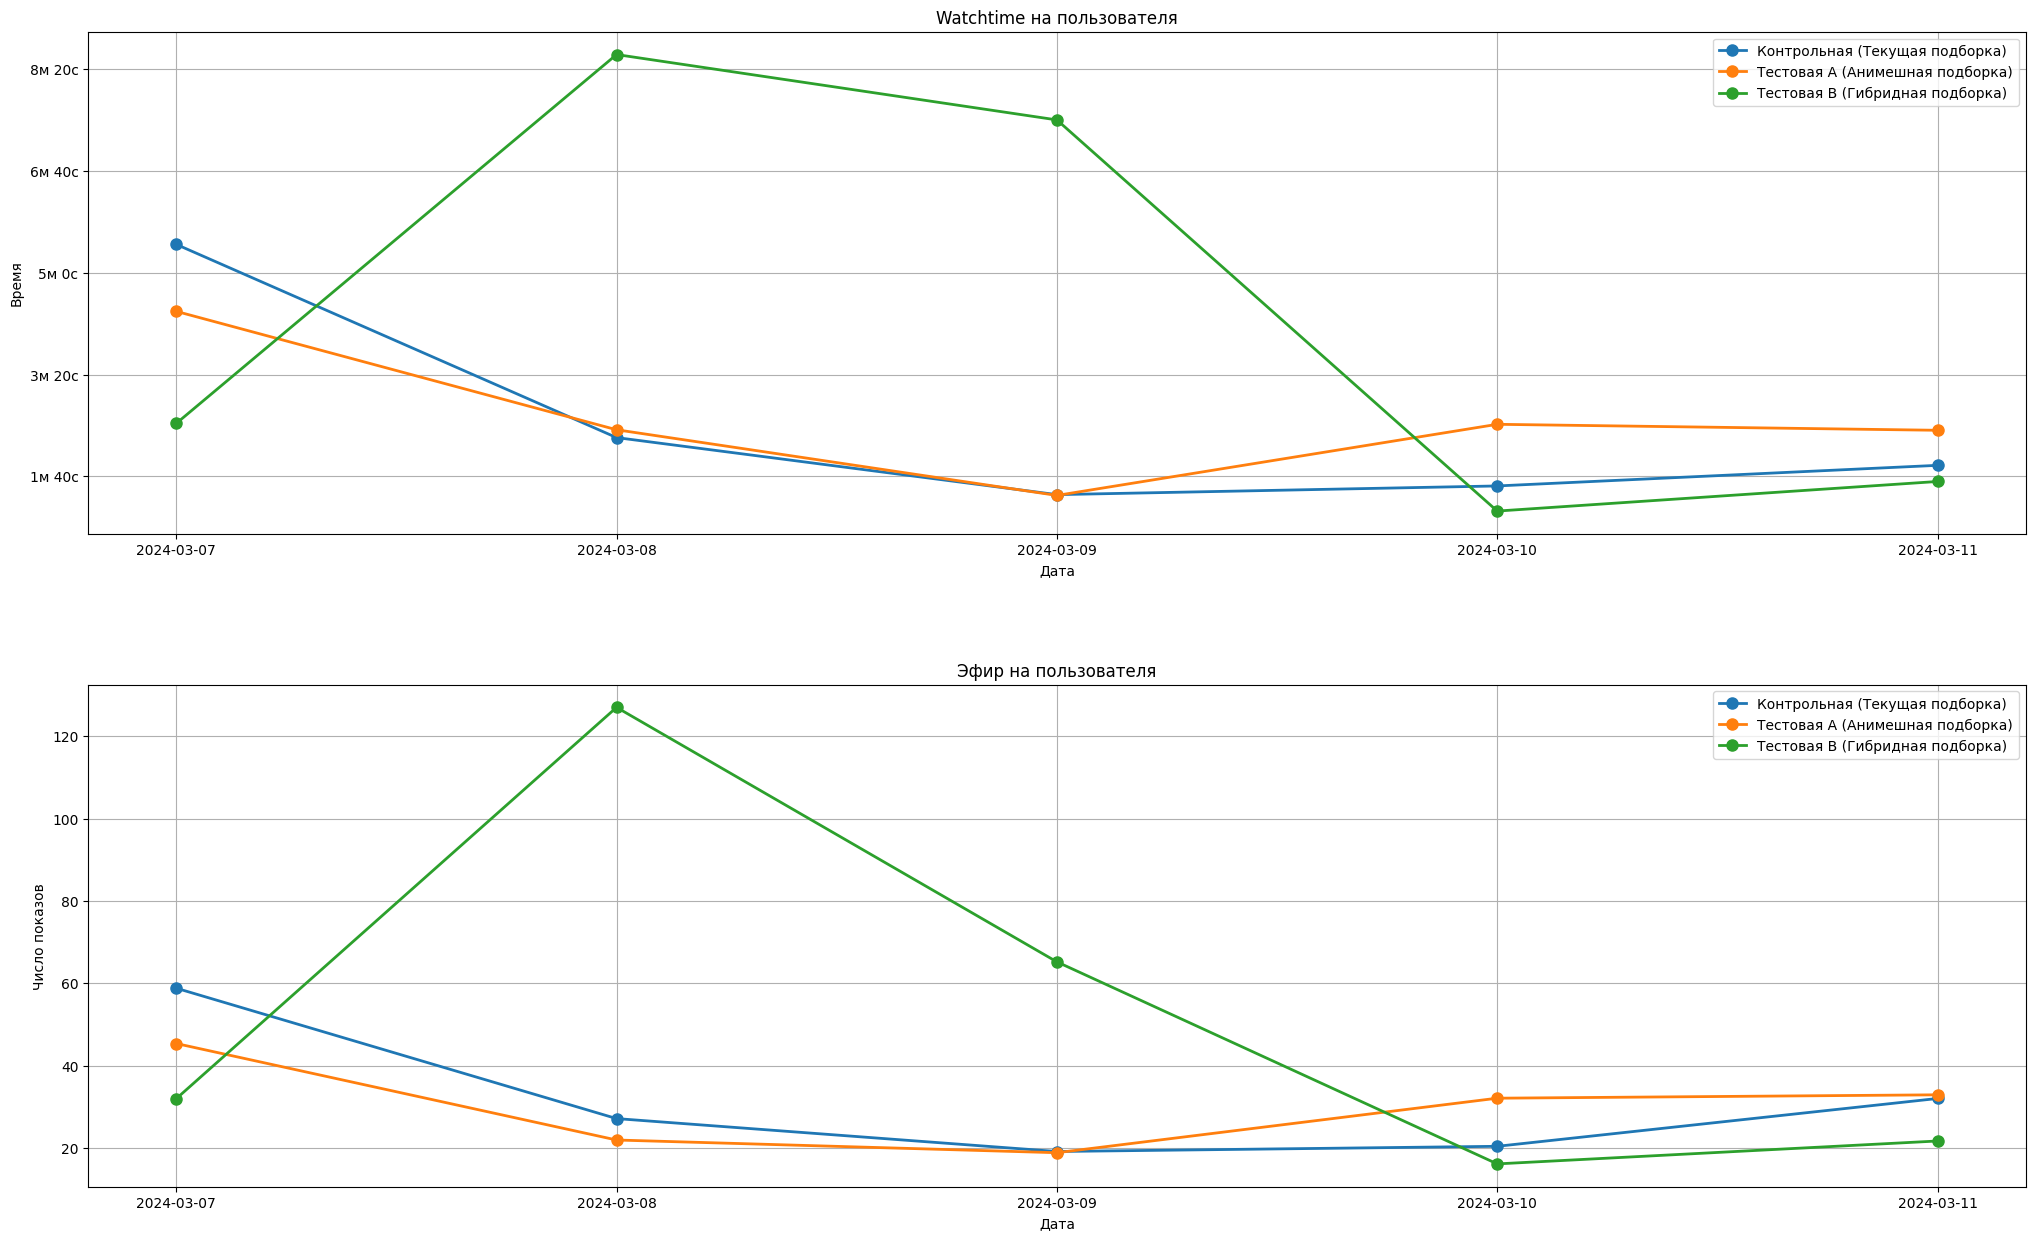

In [129]:
import matplotlib.dates as mdates

fig,axes = plt.subplots(2,1,figsize=(25,15))

def format_func(value, tick_number):
    minutes = int(value) // 60
    seconds = int(value) % 60
    return f"{minutes}м {seconds}с"

plt.subplots_adjust(hspace=0.3)

for i in cnt_watchtime_mean_std_n['experiment_group'].unique():
    watchtime = cnt_watchtime_mean_std_n[cnt_watchtime_mean_std_n['experiment_group']==i]
    axes[0].plot(watchtime['date_msk'], watchtime['mean'], label=i,marker='o',linewidth=2, markersize=8)

for i in cnt_broadcast_mean_std_n['experiment_group'].unique():
    broadcast = cnt_broadcast_mean_std_n[cnt_broadcast_mean_std_n['experiment_group']==i]    
    axes[1].plot(broadcast['date_msk'],broadcast['mean'], label=i,marker='o',linewidth=2, markersize=8)

    # заштриховываем доверительный интервал
    #plt.fill_between(t['date_msk'],t['ci_plus'],t['ci_minus'], alpha=0.2)

for i in range(2):    
    axes[i].grid(True)
    
for i in range(2):
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    
axes[0].set_xlabel('Дата')
axes[1].set_xlabel('Дата')
axes[0].set_ylabel('Время')
axes[1].set_ylabel('Число показов')
axes[0].set_title('Watchtime на пользователя')
axes[1].set_title('Эфир на пользователя')

axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
for i in range(2):
        axes[i].legend(labels=['Контрольная (Текущая подборка)', 'Тестовая А (Анимешная подборка)', 'Тестовая B (Гибридная подборка)'])
axes[0].figure.savefig(f"Watchtime и эфир только каналы Стаса '{end_date}'.jpg")
plt.show()